## Contruction of Blocks as in Example 2.1, Matthews & Taylor, with a Uniform distribution

### 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt


### 1. Data

Text(0.5, 1.0, 'Scatterplot of sample X')

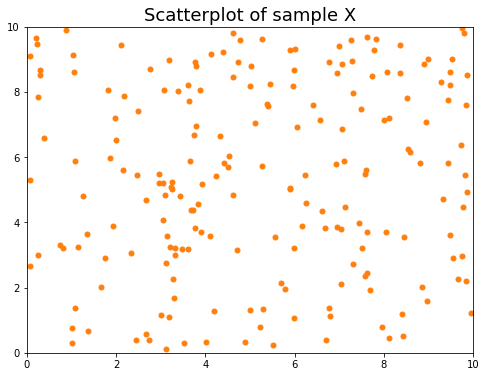

In [2]:
N = 200
X = np.empty((N,2))
X[:,0] = np.random.uniform(0,10,N)
X[:,1] = np.random.uniform(0,10,N)

plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', label = 'Data', zorder = 1, ms = 5)

plt.xlim(0,10)
plt.ylim(0,10)

plt.title('Scatterplot of sample X', fontsize=18)
# plt.legend(fontsize=18)
# plt.grid()

### 2. Cutting functions

In [7]:
# each function is arbitrary and takes one of the components of the corresponding (x1, x2)
H = np.array([1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1])
H = np.random.randint(0, 2, N)

# define the permutaions (arbitrary)
K = np.array([10, 5, 15, 3, 7, 12, 18, 2, 4, 6, 8, 11, 13, 16, 19, 1, 9, 14, 17, 20])
K = np.arange(1,N+1)
np.random.shuffle(K)

# we are going to order K and H in a diadic way
new_K = []
new_H = H
k_first = list(K)
k_first.sort()
K_List = [k_first]
K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

H_counter = []   # counter to asign values of H
h = 0
while sum(H_counter) <= len(new_H):
    H_counter.append(2**h)
    h = h+1
    
H_value = [0]*len(H_counter)    # values of H to asign
for i in range(len(H_value)):
    if i%2 == 1:
        H_value[i] = 1

for i in range(N):
    # choose list to divide
    for j in range(len(K_List)):
        if K_marker[j] == 0 and len(K_List[j]) >= 1:
            length_K = len(K_List[j])
            # choose position of new_K in the list
            K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
            new_K.append(K_List[j][K_position])
            # split the existing array            
            K_List.append(K_List[j][:K_position])
            K_List.append(K_List[j][K_position+1:])
            K_marker[j] = 1
            K_marker.append(0)
            K_marker.append(0)
            # now add elements to H_new
            break

# for each element in K, asign the corresponding element in H

for i in range(N):
    for m in range(len(H_value)):
        if i+1 <= sum(H_counter[:m+1]):
            new_H[new_K[i]-1] = H_value[m]
            break
    
H = np.array(new_H)
K = np.array(new_K)
#np.random.shuffle(H)
#np.random.shuffle(K)



### 3. Let's define a class to work with the blocks

In [8]:
class block():
    def __init__(self, vertices = None, elements = None, stats = None, parent = None, leftChild = None, rightChild = None):
        self.vertices = vertices   # array with 2 bidimensional elemntes, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partirion on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] <= xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:   # Xele > xstat
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] <= xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:   # Xele > xstat
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        # return the place where the partition was made
        return xstat

### 4. Partition: general case
#### We proceed to use the block class to apply the partition in a iterative loop

In [9]:
# create list with blocks
First_Block = block(vertices = np.array([[0,0],[10,10]]), elements = X, stats = range(1,N+2))

Blocks_List = [First_Block]

for i in range(N):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
            #print(H[K[i]-1])
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
            #print(Blocks_List[j].leftChild.stats)
            #print(Blocks_List[j].rightChild.stats)
            #print(Blocks_List[j].leftChild.elements)
            #print(Blocks_List[j].rightChild.elements)
            break

### Now we plot the finals blocks

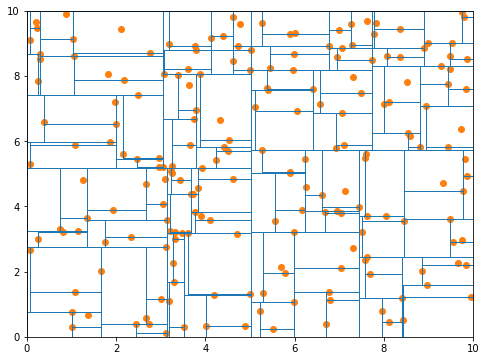

In [10]:
# plot
fig = plt.figure(figsize=(8,6))
# Bloque.plot(color = 'g')
plt.plot(X[:,0], X[:,1], 'o', color = 'C1')

plt.xlim(0,10)
plt.ylim(0,10)

for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_List[j].plot(print_num = False)
 
